# Solution to my first NN: NN with hidden layer

We are here training the MNIST set with a neural network with one hidden layer

In [1]:
import time
t = time.time()

In [2]:
%matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

from preprocessed_mnist import load_dataset

Using TensorFlow backend.


In [3]:
# Random seed
np.random.seed(42)

* Generalize to multiclass logistic regression

From `preprocessed_mnist` the data has already been:

1. Been normalized (note that the images only have one channel)
2. Split into train, validation and test

## Data preparation

In [4]:
# Load the dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()

In [5]:
# Parameters
small_number = 1e-3
machine_eps = np.finfo(float).eps
batch_size = 128
epochs = 30

nodes_in_hidden_layer = 500

In [6]:
def reshaper_3d_to_2d(var):
    """
    Reshapes a 3-d array to a 2-d array, collapsing the two last dimensions
    
    Parameters
    ----------
    var : array, shape (samples, image-rows, image-colums)
        The variable to reshape
        
    Returns
    -------
    reshaped : array, shape (samples, image-rows, image-colums)
        The reshaped variable    
    """
    
    reshaped = var.reshape(var.shape[0], var.shape[1]*var.shape[2])
    
    return reshaped

In [7]:
def one_hot(var):
    """
    One hot encoding 
    
    The input variable will be copied prior to transformation
    
    Parameters
    ----------
    var : nd-array
        The array to one hot encode
    
    Returns
    -------
    one_hot : nd-array
        The one hot encoding. This nd-array is one rank higher than the input nd-array
        
    References
    ----------
    [0] https://stackoverflow.com/questions/29831489/numpy-1-hot-array
    """

    one_hot = np.zeros((var.size, var.max()+1))
    # Fancy indexing: Array picking out indices from each dimension
    one_hot[np.arange(var.size), var] = 1 
    
    return one_hot

In [8]:
X_train_r = reshaper_3d_to_2d(X_train)
X_val_r = reshaper_3d_to_2d(X_val)
X_test_r = reshaper_3d_to_2d(X_test)

In [9]:
y_train_ohe = one_hot(y_train)
y_val_ohe = one_hot(y_val)
y_test_ohe = one_hot(y_test)

In [10]:
n_training_ex = X_train_r.shape[0]
n_features = X_train_r.shape[1]
n_output = y_train.max()+1

## Tensorflow preparation

We will use a notation similar to Michael Nielsens [notation](http://neuralnetworksanddeeplearning.com/chap2.html), but altered to be consistent with pandas [tidy data](https://github.com/pandas-dev/pandas/blob/master/doc/cheatsheet/Pandas_Cheat_Sheet.pdf) 

$X_{\text{e}, \text{f}}W^{\text{l}}_{\text{ f}, \text{t}} + \mathbb{1}_{\text{e}, 1}b_{1, \text{t}}$

* `e` - number of examples
* `l` - layer
* `f` - from node (or activation) id
* `t` - to node id

Each `to node id` is a sum of all `from node (or activation) id`.
This means that the rows are trained seperately, and only depends on the `to node id`

In [11]:
# The first dimension is None, as we would like to vary the number of input examples

input_X = tf.placeholder("float32", shape=(None, n_features), name="input_x")
input_y = tf.placeholder("float32", shape=(None, n_output), name="input_y")

ones = tf.placeholder("float32", shape=(None, 1), name='ones')

In [12]:
def get_w_and_b(n_to_nodes, n_from_nodes):
    """
    Returns weights and biases based on the input dimensions
    
    Notes
    -----
    If this function is called more than once, Tensorflow will
    automatically add an underscore and an incremental value to the name
    in order to distinguish the variables from each other
    
    Parameters
    ----------
    n_to_nodes : int
        Number of nodes in the next layer (t in notation above)
    n_from_nodes : int
        Number of nodes in the previous layer (f in notation above)
        
    Returns
    -------
    W : Variable, shape (n_from_nodes, n_to_nodes)
        The weights variable
    b : Variable, shape (n_training_ex, n_to_nodes)
        The bias variable
    """
     
    # We initialize with random weights to break symmetry
    W = tf.Variable(initial_value=np.random.randn(n_from_nodes, n_to_nodes)*small_number,
                    name="weights",
                    dtype='float32')

    b = tf.Variable(initial_value=np.random.randn(1, n_to_nodes)*small_number,
                    name="bias",
                    dtype='float32')
    
    return W, b

In [13]:
W_input_to_hidden, b_input_to_hidden = get_w_and_b(n_to_nodes=nodes_in_hidden_layer, n_from_nodes=n_features)
W_hidden_to_output, b_hidden_to_output = get_w_and_b(n_to_nodes=n_output, n_from_nodes=nodes_in_hidden_layer)

## The model code

In [14]:
hidden_activation = tf.nn.sigmoid(input_X @ W_input_to_hidden + ones @ b_input_to_hidden)

# The softmax is performed over each column (a casting to probabilities, so that the output vector sums to 1)
# NOTE: Do not confuse softmax and cross entropy loss
# https://www.quora.com/Is-the-softmax-loss-the-same-as-the-cross-entropy-loss
predicted_y = tf.nn.softmax(hidden_activation @ W_hidden_to_output + ones @ b_hidden_to_output)

# NOTE: input_y and predicted_y have dimensions (n_examples, n_labels)
#       The elementwise multiplication and subsequent mean reduction along the rows computes the loss per example
#       the subsequent mean reduction computes the mean loss over all examples
# NOTE: Adding machine epsilon as log(0) returns NaN
loss = tf.reduce_mean(- input_y * tf.log(predicted_y + machine_eps) - (1-input_y) * tf.log(1 - predicted_y + machine_eps))

# NOTE: Different optimizers were tricky to optimize, got best result with Adam using standard parameters
optimizer = tf.train.AdamOptimizer(learning_rate=0.001,
                                   beta1=0.9,
                                   beta2=0.999,
                                   epsilon=1e-08,).minimize(loss)

## Initializations and definition of the batch generator

In [15]:
class Batch(object):
    """
    Class to generate batches without replacement.
    
    Inspired by [0].
    
    References
    ----------
    [0] https://medium.com/wwblog/getting-started-with-tensorflow-a65bc824141b
    """
    
    def __init__(self, X, y, batch_size):
        """
        Set the member data and generates the indices
        
        Parameters
        ----------
        X : array, shape (n_examples, n_features)
            The data matrix
        y : array, shape (n_examples, 1)
            The ground truth
        """
        self.batch_size = batch_size
        self.X = X
        self.y = y
        
        size = y.shape[0]
        
        if batch_size > size:
            print('batch_size > size, setting batch_size = size')
            self.batch_size = size
        
        # Random shuffling of the indices
        self.indices = np.array(range(size))
        np.random.shuffle(self.indices)
        
        self.get_next_indices = self.indices_generator()
        
    def indices_generator(self):
        """
        Generator which returns indices
        """
        
        for i in range(self.indices.shape[0] // self.batch_size):
            yield self.indices[i*self.batch_size:i*self.batch_size + self.batch_size]         
    
    def get_batch(self):
        """
        Rerurns a batch
        
        Returns
        -------
        X : array, shape (batch_size, n_features)
            The data matrix
        y : array, shape (batch_size, 1)
            The ground truth
        """
        
        try:
            indices = next(self.get_next_indices)
        except StopIteration:
            # Replenish exhausted generator
            self.get_next_indices = self.indices_generator()
            indices = next(self.get_next_indices)

        X = self.X[indices, :]
        y = self.y[indices, :]
        return X, y

Calculate iteration

In [16]:
if batch_size > n_training_ex:
    batch_size = n_training_ex

iter_per_epoch = n_training_ex // batch_size
total_iter = iter_per_epoch * epochs

Initialize ones

In [17]:
minibatch_ones = np.ones([batch_size, 1])
train_ones = np.ones([y_train_ohe.shape[0], 1])
validation_ones = np.ones([y_val_ohe.shape[0], 1])
test_ones = np.ones([y_test_ohe.shape[0], 1])

Initialize plotting variables

In [18]:
training_loss = np.zeros(epochs)
validation_loss = np.zeros(epochs)
test_loss = np.zeros(epochs)

epoch_array = np.array(range(epochs), dtype=int)

## Training

In [19]:
sess = tf.Session()

# The variables must be initialized
# https://stackoverflow.com/questions/44299666/when-global-variables-initializer-is-actually-required
sess.run(tf.global_variables_initializer())

batch = Batch(X_train_r, y_train_ohe, batch_size)

In [20]:
iteration = 1
for epoch in range(epochs):
    for batch_nr in range(iter_per_epoch):
        print(f'Epoch: {epoch + 1}/{epochs}, '
              f'Mini batch: {batch_nr + 1}/{iter_per_epoch}, '
              f'Total iteration: {iteration}/{total_iter}', end='\r')
        
        iteration += 1
        
        X, y = batch.get_batch()
        
        sess.run(optimizer, 
         {input_X: X,
          input_y: y,
          ones: minibatch_ones})
            
    training_loss[epoch] = sess.run(loss, 
                                    {input_X: X_train_r,
                                     input_y: y_train_ohe,
                                     ones: train_ones})
    
    validation_loss[epoch] = sess.run(loss, 
                                      {input_X: X_val_r, 
                                       input_y: y_val_ohe,
                                       ones: validation_ones})
    test_loss[epoch] = sess.run(loss,
                                {input_X: X_test_r, 
                                 input_y: y_test_ohe,
                                 ones: test_ones})
    
    epoch += 1

## Prediction

In [21]:
y_pred_train_ohe = sess.run(predicted_y, 
                            {input_X: X_train_r, 
                             ones: train_ones})
y_pred_validation_ohe = sess.run(predicted_y, 
                                 {input_X: X_val_r, 
                                  ones: validation_ones})
y_pred_test_ohe = sess.run(predicted_y, 
                           {input_X: X_test_r, 
                            ones: test_ones})

In [22]:
sess.close()

In [23]:
# Taking argmax of the predictions
y_pred_train = np.argmax(y_pred_train_ohe, axis=1)
y_pred_validation = np.argmax(y_pred_validation_ohe, axis=1)
y_pred_test = np.argmax(y_pred_test_ohe, axis=1)

### Plotting loss

In [24]:
# Calc f-score
f_score_train = f1_score(y_pred_train, y_train, average='micro')
f_score_validation = f1_score(y_pred_validation, y_val, average='micro')
f_score_test = f1_score(y_pred_test, y_test, average='micro')

accuracy_train = accuracy_score(y_pred_train, y_train)
accuracy_validation = accuracy_score(y_pred_validation, y_val)
accuracy_test = accuracy_score(y_pred_test, y_test)

<IPython.core.display.Javascript object>


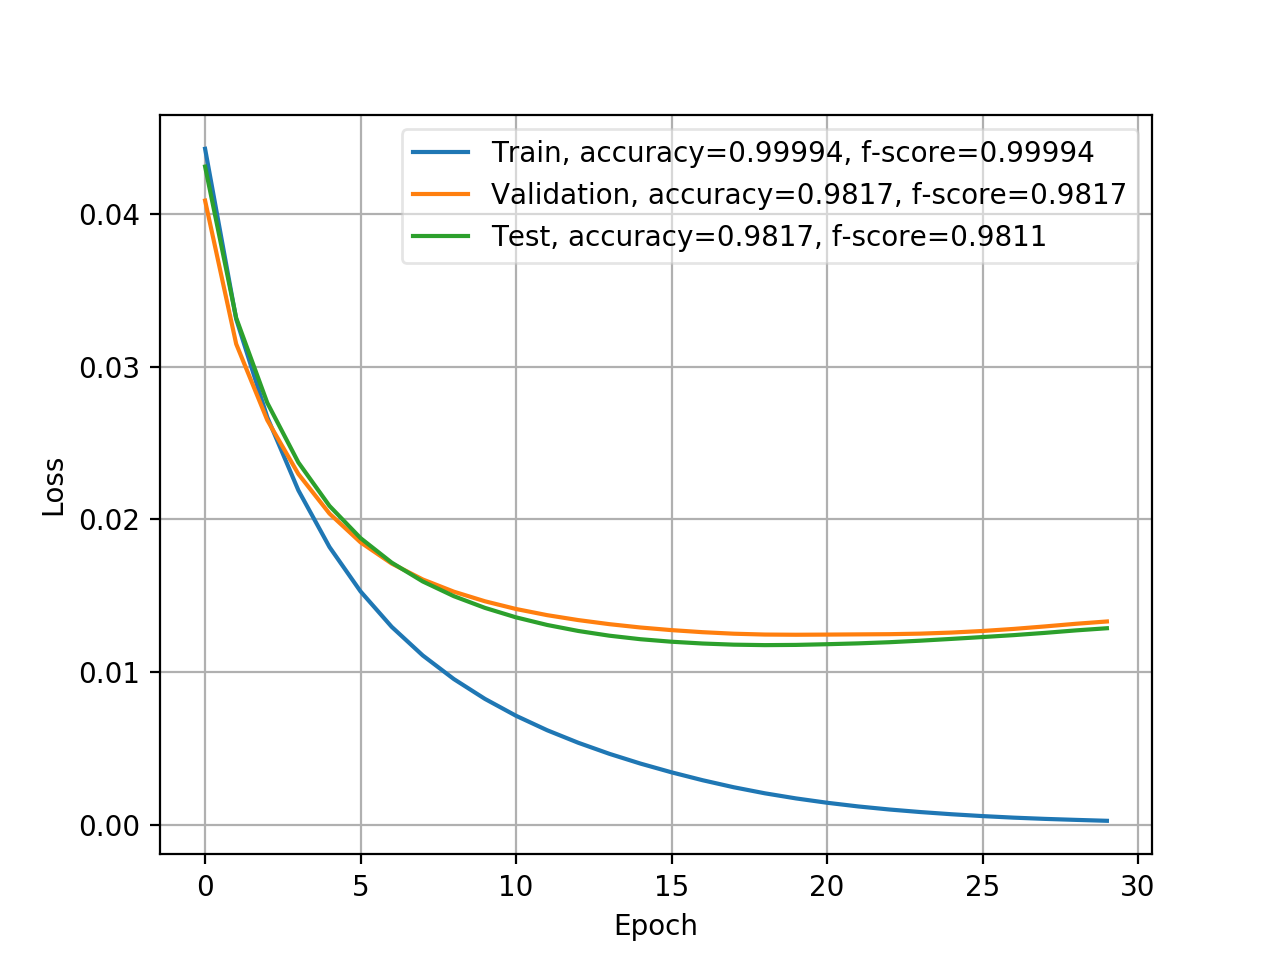

In [25]:
fig, ax = plt.subplots()

ax.plot(epoch_array, training_loss, label=f'Train, accuracy={accuracy_train:.5}, f-score={f_score_train:.5}')
ax.plot(epoch_array, validation_loss, label=f'Validation, accuracy={accuracy_validation:.5}, f-score={f_score_validation:.5}')
ax.plot(epoch_array, test_loss, label=f'Test, accuracy={accuracy_validation:.5}, f-score={f_score_test:.5}')

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

ax.grid()

_ = ax.legend(loc='best', fancybox=True, framealpha=0.5)

### Plotting highest and lowest prediction probability

<IPython.core.display.Javascript object>


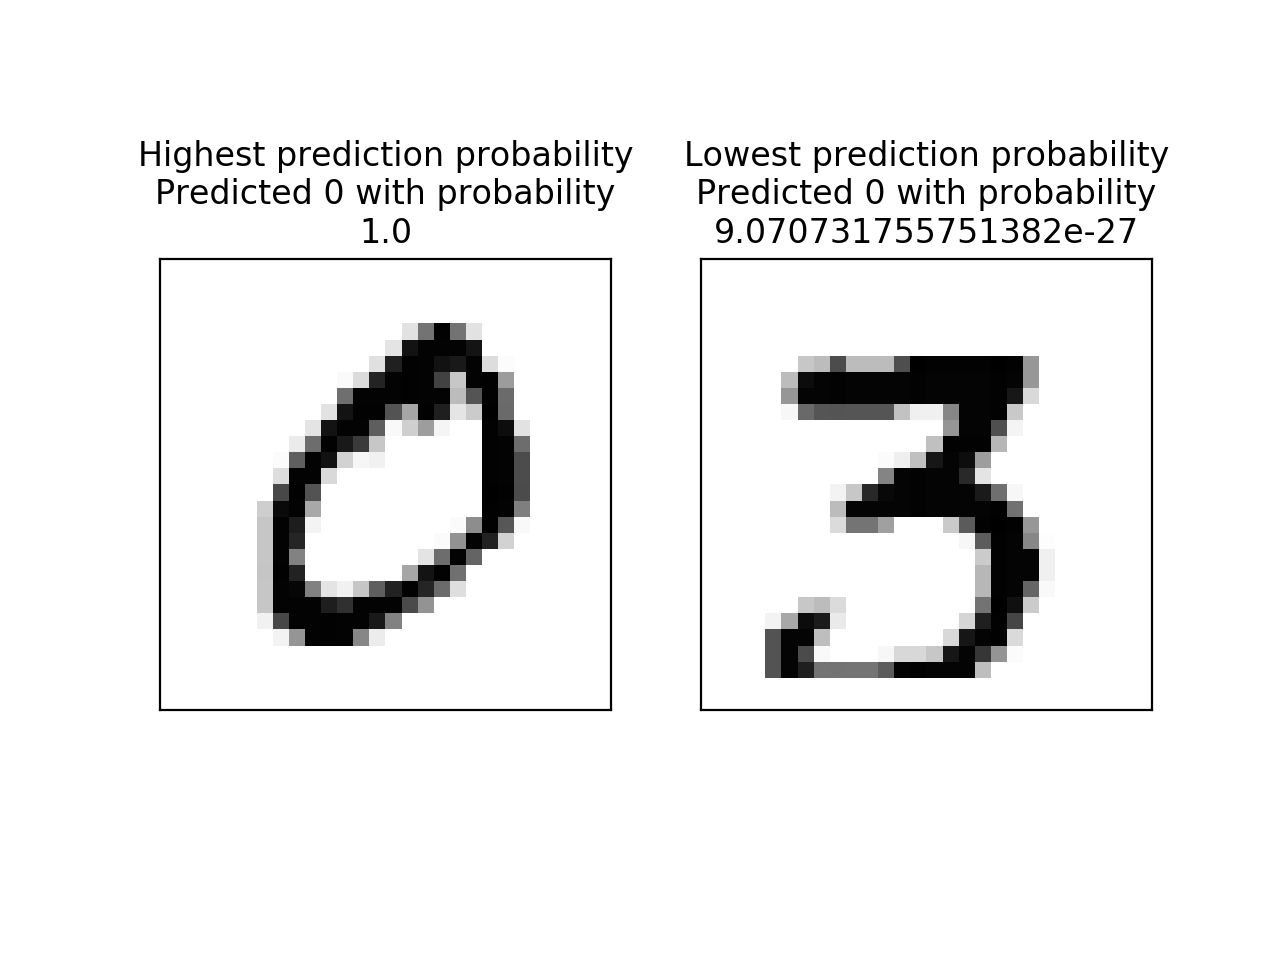

In [26]:
largest_ind = np.where(y_pred_train_ohe == y_pred_train_ohe.max())
lowest_ind = np.where(y_pred_train_ohe == y_pred_train_ohe.min())

title_1 = (f'Highest prediction probability\n'
           f'Predicted {y_pred_train[largest_ind[0][0]]} with probability\n'
           f'{y_pred_train_ohe[largest_ind][0]}')
title_2 = (f'Lowest prediction probability\n'
           f'Predicted {y_pred_train[largest_ind[0][0]]} with probability\n'
           f'{y_pred_train_ohe[lowest_ind][0]}')

fig, (ax1, ax2) = plt.subplots(ncols=2)

ax1.imshow(X_train[largest_ind[0][0]], cmap="Greys")
_ = ax1.set_title(title_1)

ax2.imshow(X_train[lowest_ind[0][0]], cmap="Greys")
_ = ax2.set_title(title_2)

ax1.xaxis.set_major_locator(plt.NullLocator())
ax1.yaxis.set_major_locator(plt.NullLocator())
ax2.xaxis.set_major_locator(plt.NullLocator())
ax2.yaxis.set_major_locator(plt.NullLocator())

In [27]:
print(f'test accuracy={accuracy_test}\nelapsed = {(time.time() - t)/60:.2f} minutes')

test accuracy=0.9811
elapsed = 2.63 minutes
